# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы и контролировать добросовестность кассиров при продаже алкоголя. Строится модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')
#images = '/datasets/faces/final_files'
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


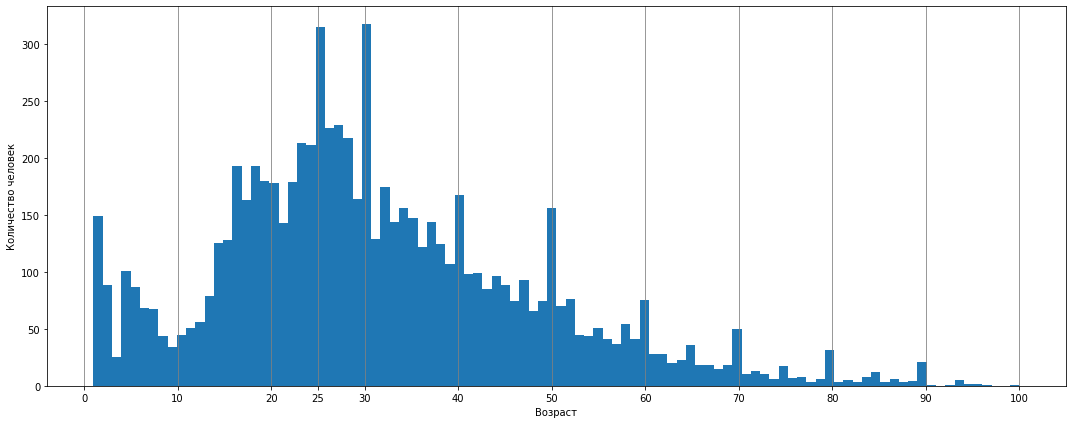

In [9]:
fig, axs = plt.subplots(1, 1,
                        figsize =(15, 6),
                        tight_layout = True)
axs.grid(b = True, color ='grey', axis= 'x')
axs.set_xticks([0, 10,20,  25, 30, 40, 50, 60, 70, 80, 90, 100])
plt.hist(data['real_age'], bins=100)
axs.set_xlabel('Возраст') 
axs.set_ylabel('Количество человек');

Прослеживаются некоторые выделяющиеся значения на круглых датах (30, 40, 50...) Скорее всего, при опросе, многие владельцы лиц с фотографии округляли свой возраст до ближайшего "красивого" числа. Для нашей бизнес задачи (исключить продажу алкоголя несовершеннолетним и предложить товары, которые могут заинтересовать ту или иную категорию граждан по возрасту) подобные искажения не являются чем-то критическим, возраст +/- пять лет не сильно влияет на предпочтения.

In [6]:
datagen = ImageDataGenerator(rescale = 1./255)
datagen_flow = datagen.flow_from_dataframe(
    dataframe=data,
    directory = '/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


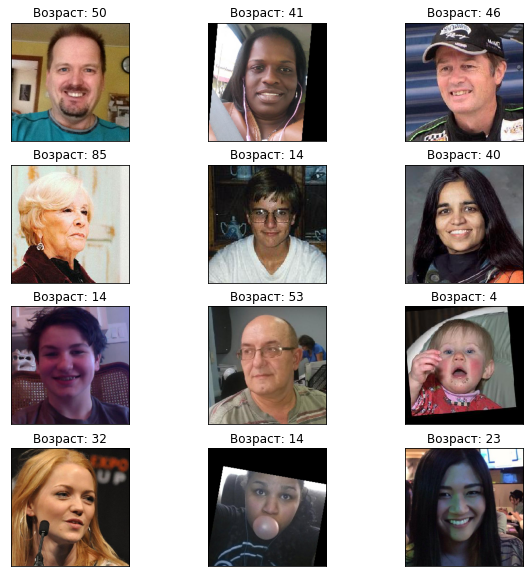

In [7]:
features, target = next(datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Возраст: {target[i]}')
    #plt.tight_layout()
    

Датасет содержит семь с половиной тысяч фотографий людей разных возрастов. Фотографии не приведены к одному "серийному" виду, положение головы, мимка, вид фотографий отличаются от фотографии к фотографии. Распределение возрастов близко к нормальному, медиана проходит на уровне 31 года, в данных присутствуют все возраста от 1 до 100 лет. Целевой признак (возраст) соответствует лицу на фотографии.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [ ]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import pandas as pd

def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255,                                 
                                 horizontal_flip=True,
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory = path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)
    
    return train_datagen_flow

def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=data,
        directory = path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'validation',
        seed=12345)
    
    return test_datagen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer_adam = Adam(learning_rate=0.0001)
    model.compile(loss=MeanSquaredError(), optimizer=optimizer_adam, metrics=['mae'])
    
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=6, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              batch_size=batch_size, 
              epochs=epochs, 
              verbose=2)
    return model 


```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/6
2023-02-18 08:08:40.067702: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-18 08:08:40.646636: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 101s - loss: 241.3257 - mae: 11.3512 - val_loss: 471.5773 - val_mae: 16.6271
Epoch 2/6
178/178 - 99s - loss: 99.7667 - mae: 7.5533 - val_loss: 471.5361 - val_mae: 16.6409
Epoch 3/6
178/178 - 99s - loss: 80.2911 - mae: 6.7998 - val_loss: 580.9690 - val_mae: 19.1319
Epoch 4/6
178/178 - 98s - loss: 67.4347 - mae: 6.2937 - val_loss: 115.2360 - val_mae: 8.0049
Epoch 5/6
178/178 - 99s - loss: 59.1073 - mae: 5.8641 - val_loss: 97.8502 - val_mae: 7.4775
Epoch 6/6
178/178 - 99s - loss: 49.8763 - mae: 5.4272 - val_loss: 71.3431 - val_mae: 6.3206
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 71.3431 - mae: 6.3206
Test MAE: 6.3206



```

## Анализ обученной модели

В нашем распоряжении датасет c семью с половиной тысячью лиц. 
В ходе исследовательского анализа было выявленно:  

- возрасты соответствуют портретам; в целом распределенны нормально, однако прослеживаются выделяющиеся значения вблизи круглых дат.
- портреты не приведены к одному типовому виду, встречаются картинки, которые не подходят для нашей задачи (человек в кадре стоит в полный рост, лицо почти не видно, плохое качество)  

Для обучения модели распознавания возраста за основу была взята архитектура ResNet50 с предобученными весами, адаптированная для нашей задачи регрессии: Бэкбон из ResNet с 50 слоями и голова с одним слоем глобальнгого пула и одним нейроном с активаторами 'ReLU'.
Параметры обучения:  
- Размер батча: 32 фотографий
- Оптимизатор: АДАМ с шагом 0.0001
- Заморозка весов бэкбона не использовалась, количестива фотографий достаточно.
- Количество эпох: 6  

Модель показала среднюю абсолютную ошибку на тесте 6,3 лет, что является удовлетворительным результатом для нашей задачи, переобучения модели проявлялось про количестве эпох более 6.